In [0]:
!pip install -q tensorflow==2.1.0

In [0]:
!pip install -q tensorflow-quantum

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
'''
q = cirq.GridQubit(0, 0)
a = sympy.symbols('a')
circuit = cirq.Circuit(
    cirq.ry(a)(q)
)

outputs = tfq.layers.PQC(circuit, cirq.Z(q))
quantum_data = tfq.convert_to_tensor([cirq.Circuit()])
outputs(quantum_data)
'''

"\nq = cirq.GridQubit(0, 0)\na = sympy.symbols('a')\ncircuit = cirq.Circuit(\n    cirq.ry(a)(q)\n)\n\noutputs = tfq.layers.PQC(circuit, cirq.Z(q))\nquantum_data = tfq.convert_to_tensor([cirq.Circuit()])\noutputs(quantum_data)\n"

In [179]:
x_train=2*np.random.rand(800,1,1,1)-1
x_test=2*np.random.rand(200,1,1,1)-1

#y_train=-np.abs(np.reshape(x_train,(-1,1)))+0.5
#y_test=-np.abs(np.reshape(x_test,(-1,1)))+0.5
#y_train=4*(np.abs(np.abs(np.reshape(x_train,(-1,1)))-0.5)-0.25)
#y_test=4*(np.abs(np.abs(np.reshape(x_test,(-1,1)))-0.5)-0.25)
y_train=np.cos(x_train*np.pi)
y_test=np.cos(x_test*np.pi)

np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test)

((800, 1, 1, 1), (200, 1, 1, 1), (800, 1, 1, 1), (200, 1, 1, 1))

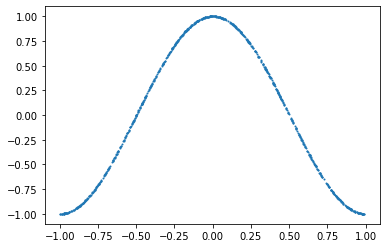

In [180]:
plt.scatter(np.reshape(x_train,-1),y_train,s=1)

In [0]:
def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(1,1)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        circuit.append(cirq.ry(np.pi*value).on(qubits[i]))
        #if value: circuit.append(cirq.X(qubits[i]))
    return circuit

x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

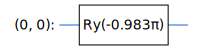

In [182]:
SVGCircuit(x_train_circ[0])

In [0]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [184]:
'''
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

def create_quantum_model():
    data_qubits = cirq.GridQubit.rect(1,1) 
    readout = cirq.GridQubit(-1, -1)       
    circuit = cirq.Circuit()
    
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)
'''

'\nclass CircuitLayerBuilder():\n    def __init__(self, data_qubits, readout):\n        self.data_qubits = data_qubits\n        self.readout = readout\n    \n    def add_layer(self, circuit, gate, prefix):\n        for i, qubit in enumerate(self.data_qubits):\n            symbol = sympy.Symbol(prefix + \'-\' + str(i))\n            circuit.append(gate(qubit, self.readout)**symbol)\n\ndef create_quantum_model():\n    data_qubits = cirq.GridQubit.rect(1,1) \n    readout = cirq.GridQubit(-1, -1)       \n    circuit = cirq.Circuit()\n    \n    circuit.append(cirq.X(readout))\n    circuit.append(cirq.H(readout))\n    \n    builder = CircuitLayerBuilder(\n        data_qubits = data_qubits,\n        readout=readout)\n\n    builder.add_layer(circuit, cirq.XX, "xx1")\n    builder.add_layer(circuit, cirq.ZZ, "zz1")\n\n    circuit.append(cirq.H(readout))\n\n    return circuit, cirq.Z(readout)\n'

In [0]:
def create_quantum_model():
    q = cirq.GridQubit(0, 0)
    (a,b,c) = sympy.symbols("a b c")
    circuit = cirq.Circuit(
      cirq.rx(a)(q),
      cirq.ry(b)(q),
      cirq.rz(c)(q)
    )
    return circuit, cirq.Z(q)

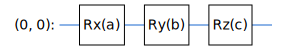

In [186]:
circuit,readout = create_quantum_model()
SVGCircuit(circuit)

In [0]:
model_circuit, model_readout = create_quantum_model()

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout)
])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_8 (PQC)                  (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


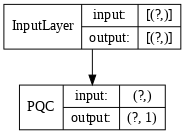

In [189]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam())

print(model.summary())

tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False,dpi=70)

In [0]:
EPOCHS = 100
BATCH_SIZE = 32

In [197]:
qnn_history = model.fit(
      x_train_tfcirc, y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 0s 292us/sample - loss: 0.8048 - val_loss: 0.8068
Epoch 2/100
800/800 [==============================] - 0s 263us/sample - loss: 0.7987 - val_loss: 0.7904
Epoch 3/100
800/800 [==============================] - 0s 255us/sample - loss: 0.7780 - val_loss: 0.7738
Epoch 4/100
800/800 [==============================] - 0s 282us/sample - loss: 0.7607 - val_loss: 0.7572
Epoch 5/100
800/800 [==============================] - 0s 266us/sample - loss: 0.7474 - val_loss: 0.7406
Epoch 6/100
800/800 [==============================] - 0s 299us/sample - loss: 0.7229 - val_loss: 0.7248
Epoch 7/100
800/800 [==============================] - 0s 293us/sample - loss: 0.7026 - val_loss: 0.7096
Epoch 8/100
800/800 [==============================] - 0s 272us/sample - loss: 0.6883 - val_loss: 0.6948
Epoch 9/100
800/800 [==============================] - 0s 262us/sample - loss: 0.6752 - val_loss: 0.6807
Epoch 10/

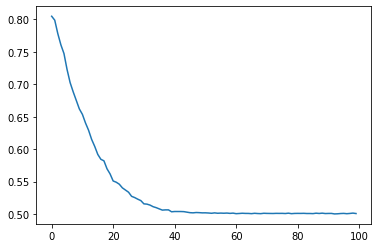

In [198]:
plt.plot(qnn_history.history['loss'])

In [0]:
y_pred=model.predict(x_train_tfcirc)

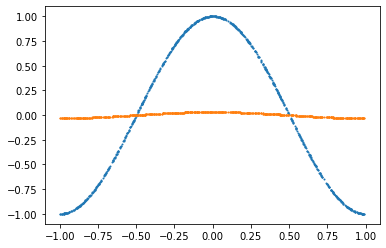

In [200]:
plt.scatter(np.reshape(x_train,-1),y_train,s=1)
plt.scatter(np.reshape(x_train,-1),y_pred,s=1)

In [201]:
model.weights

[<tf.Variable 'parameters:0' shape=(3,) dtype=float32, numpy=array([4.7435088e+00, 7.8512414e-05, 6.0375638e+00], dtype=float32)>]